# Preprocessing

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

key_variables = ['Runtime', 'Total Energy', 'Power', 'Peak Meory']

path = '/Users/hatim/Documents/Projects/Comp/Aggredated Data/'
languages = ['C', 'C++', 'Java', 'Python']


df = pd.DataFrame()

for language in languages:
    data = pd.read_csv(path+language+'.csv')
    # drop mid_temp
    data = data.drop(['mid_temp'], axis=1)
    # rearrange columns
    data['Language'] = language
    df = pd.concat([df, data], ignore_index=True)

# convert version to strings
# df['Version'] = df['Version'].astype(str)
# create columns for Total Energy, Power, 
df['Total Energy'] = df['package']+df['dram']
df['Power'] = df['Total Energy']/df['duration']
# rename duration to Runtime, and peak rss to peak memory
df = df.rename(columns={'duration':'Runtime', 'peak_rss':'Peak Memory', 'final_temp':'Final Temp'})
df = df[['Language','Algorithm', 'Version', 'Runtime', 'Total Energy', 'Peak Memory', 'Power', 'Final Temp', 'package', 'dram']]

df.head()

# get mean dataset - group by language, algorithm, version
df_mean = df.groupby(['Language', 'Algorithm', 'Version']).mean().reset_index()

# df - contains all the data
# df_mean - contains mean data grouped by language, algorithm, version


In [5]:
df[(df['Language']=='C')]['Version'].unique()

array([ 3.7,  5. ,  7. ,  6. ,  4. , 14. , 12. ,  8. , 10. , 15. ,  3.8,
       11.1, 13. ,  3.4,  3.5,  3.6])

# RQ1 - Has compiler performance in terms of key variables evolved over time?

In [8]:
from scipy.stats import shapiro, levene, f_oneway, kruskal
def perform_comprehensive_analysis(data, variable):
    comprehensive_results = {}

    for language in data['Language'].unique():
        lang_results = {}
        lang_data = data[data['Language'] == language]

        for algorithm in lang_data['Algorithm'].unique():
            alg_data = lang_data[lang_data['Algorithm'] == algorithm]
            grouped_data = [group[variable].values for name, group in alg_data.groupby("Version")]

            # Ensure there are at least two groups with more than three data points
            if len(grouped_data) >= 2 and all(len(group) > 3 for group in grouped_data):
                # Check for normality and equal variances
                normality_passed = all(shapiro(group)[1] > 0.05 for group in grouped_data)
                equal_variances_passed = levene(*grouped_data)[1] > 0.05

                # Perform appropriate test based on assumptions
                if normality_passed and equal_variances_passed:
                    # ANOVA
                    test_result = f_oneway(*grouped_data)
                else:
                    # Kruskal-Wallis Test
                    test_result = kruskal(*grouped_data)

                lang_results[algorithm] = test_result
            else:
                lang_results[algorithm] = ("Insufficient data",)

        comprehensive_results[language] = lang_results
    
    df = pd.DataFrame(comprehensive_results)
    # where the p-value is less than 0.05, there is a significant difference in the dram usage. get a df which says significant or not significant
    df_tf = df.applymap(lambda x: 'Significant' if isinstance(x, tuple) and x[1] < 0.05 else 'Not Significant' if isinstance(x, tuple) else 'N/A')
    df_tf = df_tf.reset_index()
    df_tf = df_tf.rename(columns={'index':'Algorithm'})


    return df, df_tf

# Performing the comprehensive analysis using the df dataset with the adjusted approach
_,dram_significance = perform_comprehensive_analysis(df, 'Peak Memory')
dram_significance





/var/folders/sx/705n1pb94rq1x2q_s1l8lfv80000gn/T/ipykernel_77967/1607894016.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_tf = df.applymap(lambda x: 'Significant' if isinstance(x, tuple) and x[1] < 0.05 else 'Not Significant' if isinstance(x, tuple) else 'N/A')


,Algorithm,C,C++,Java,Python
0,spectralnorm,Not Significant,Not Significant,Significant,Significant
1,nbody,Not Significant,Not Significant,Significant,Significant
2,regexredux,Not Significant,Not Significant,Significant,Significant
3,revcomp,Significant,Significant,Significant,Significant
4,mandelbrot,Not Significant,Not Significant,Significant,Significant
5,fasta,Significant,Not Significant,Significant,Significant
6,fannkuchredux,Significant,Not Significant,Significant,Significant
7,bintrees,Not Significant,Not Significant,Significant,Significant
8,knucleotide,Significant,N/A,Significant,Significant
9,pidigits,Not Significant,Not Significant,Significant,Significant


/var/folders/sx/705n1pb94rq1x2q_s1l8lfv80000gn/T/ipykernel_77967/1607894016.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_tf = df.applymap(lambda x: 'Significant' if isinstance(x, tuple) and x[1] < 0.05 else 'Not Significant' if isinstance(x, tuple) else 'N/A')
/var/folders/sx/705n1pb94rq1x2q_s1l8lfv80000gn/T/ipykernel_77967/1607894016.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_tf = df.applymap(lambda x: 'Significant' if isinstance(x, tuple) and x[1] < 0.05 else 'Not Significant' if isinstance(x, tuple) else 'N/A')
/var/folders/sx/705n1pb94rq1x2q_s1l8lfv80000gn/T/ipykernel_77967/1607894016.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_tf = df.applymap(lambda x: 'Significant' if isinstance(x, tuple) and x[1] < 0.05 else 'Not Significant' if isinstance(x, tuple) else 'N/A')
/var/folders/sx/705n1pb94rq1x2q_s1l8lfv80000gn/T/ipykernel_77967/16078

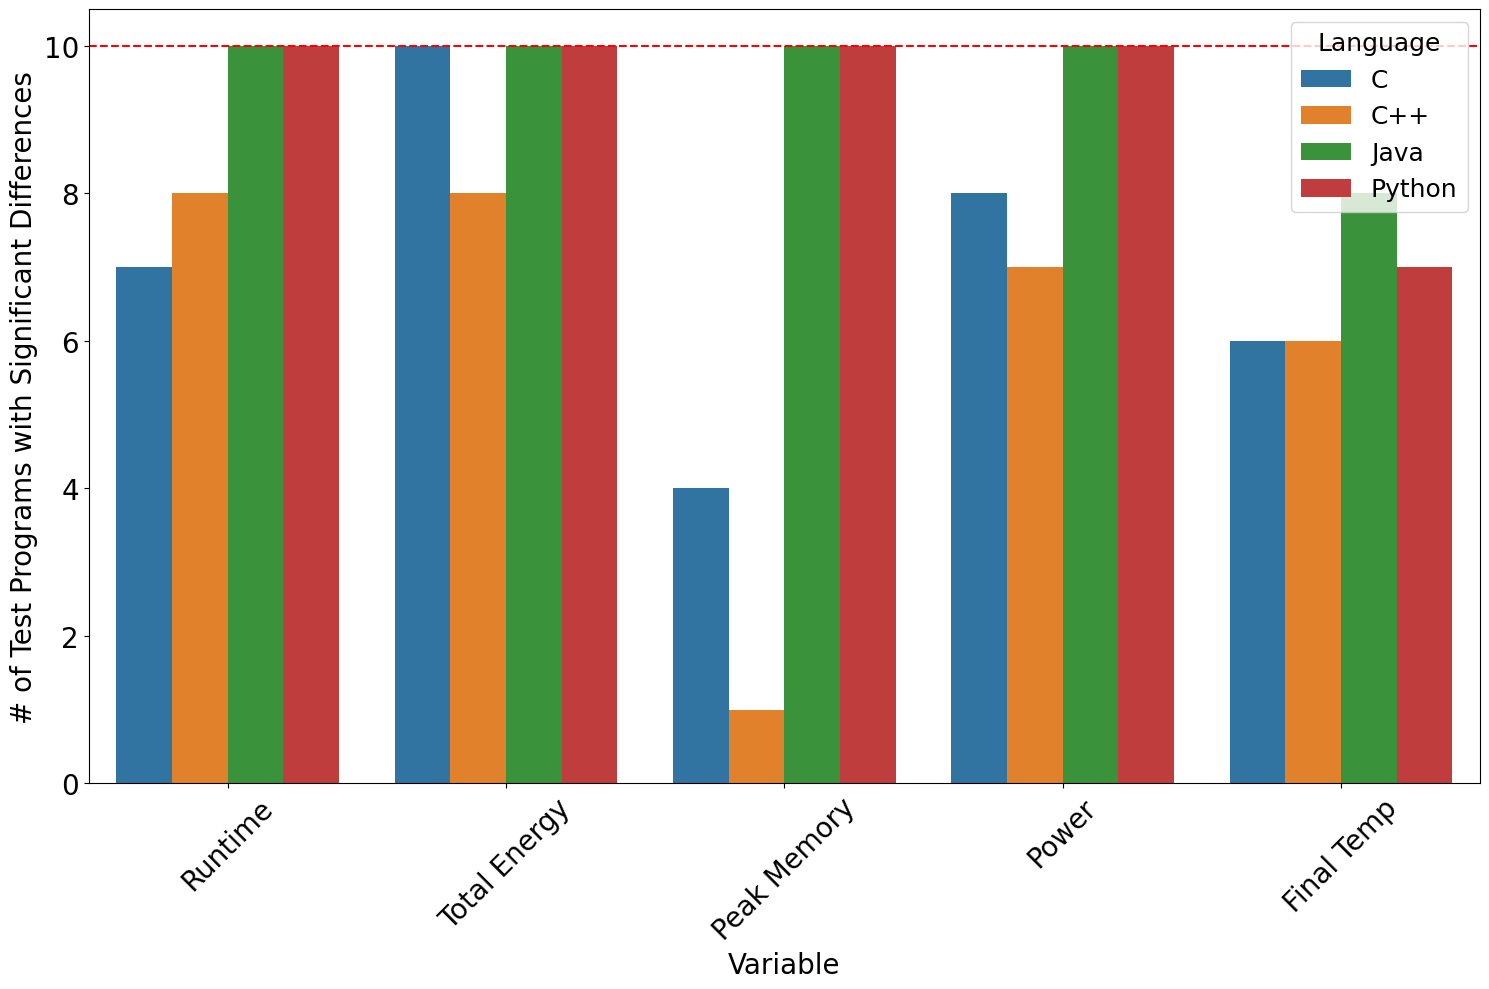

In [14]:
vars=['Runtime', 'Total Energy', 'Peak Memory', 'Power', 'Final Temp']
significance_df = pd.DataFrame()
for var in vars:
    _,significance = perform_comprehensive_analysis(df, var)
    significance['Variable'] = var
    significance_df = pd.concat([significance_df, significance], axis=0, ignore_index=True)

for var in significance_df['Variable'].unique():
    new = significance_df[significance_df['Variable'] == var]
    new = new.drop(['Variable', 'Algorithm'], axis=1)

# Resetting the index and dropping the 'Algorithm' column
significance_df_reset = significance_df.drop(columns='Algorithm').reset_index(drop=True)

# Preparing a new DataFrame to store the counts
count_data_all = pd.DataFrame()

for var in vars:
    for language in ['C', 'C++', 'Java', 'Python']:
        # Filter data for the current variable and language
        filtered_data = significance_df_reset[significance_df_reset['Variable'] == var]

        # Count the occurrences of 'Significant'
        count_series = filtered_data[language].dropna().value_counts()

        sig_count = count_series['Significant'] if 'Significant' in count_series.index else 0
        not_sig_count = count_series['Not Significant'] if 'Not Significant' in count_series.index else 0

        if sig_count + not_sig_count > 0:
            sig_percentage = (sig_count)
        else:
            sig_percentage = 0

        # Append to the DataFrame
        count_data_all = pd.concat([count_data_all, pd.DataFrame({'Language': [language], 'Variable': [var], '# of Test Programs with Significant Differences': [sig_percentage]})], ignore_index=True)



# Plotting the combined data for all variables and languages
plt.figure(figsize=(15, 10))
sns.barplot(x='Variable', y='# of Test Programs with Significant Differences', hue='Language', data=count_data_all)
plt.xticks(rotation=45, fontsize=20)
plt.xlabel('Variable', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('# of Test Programs with Significant Differences', fontsize=20)
plt.legend(title='Language', title_fontsize='18', fontsize='18')
plt.axhline(y=10, color='red', linestyle='--')
plt.tight_layout()
plt.show()

count_data_all.set_index('Language', inplace=True)
count_data_all.to_excel('Significance.xlsx')


# Trends

General Trend Lines

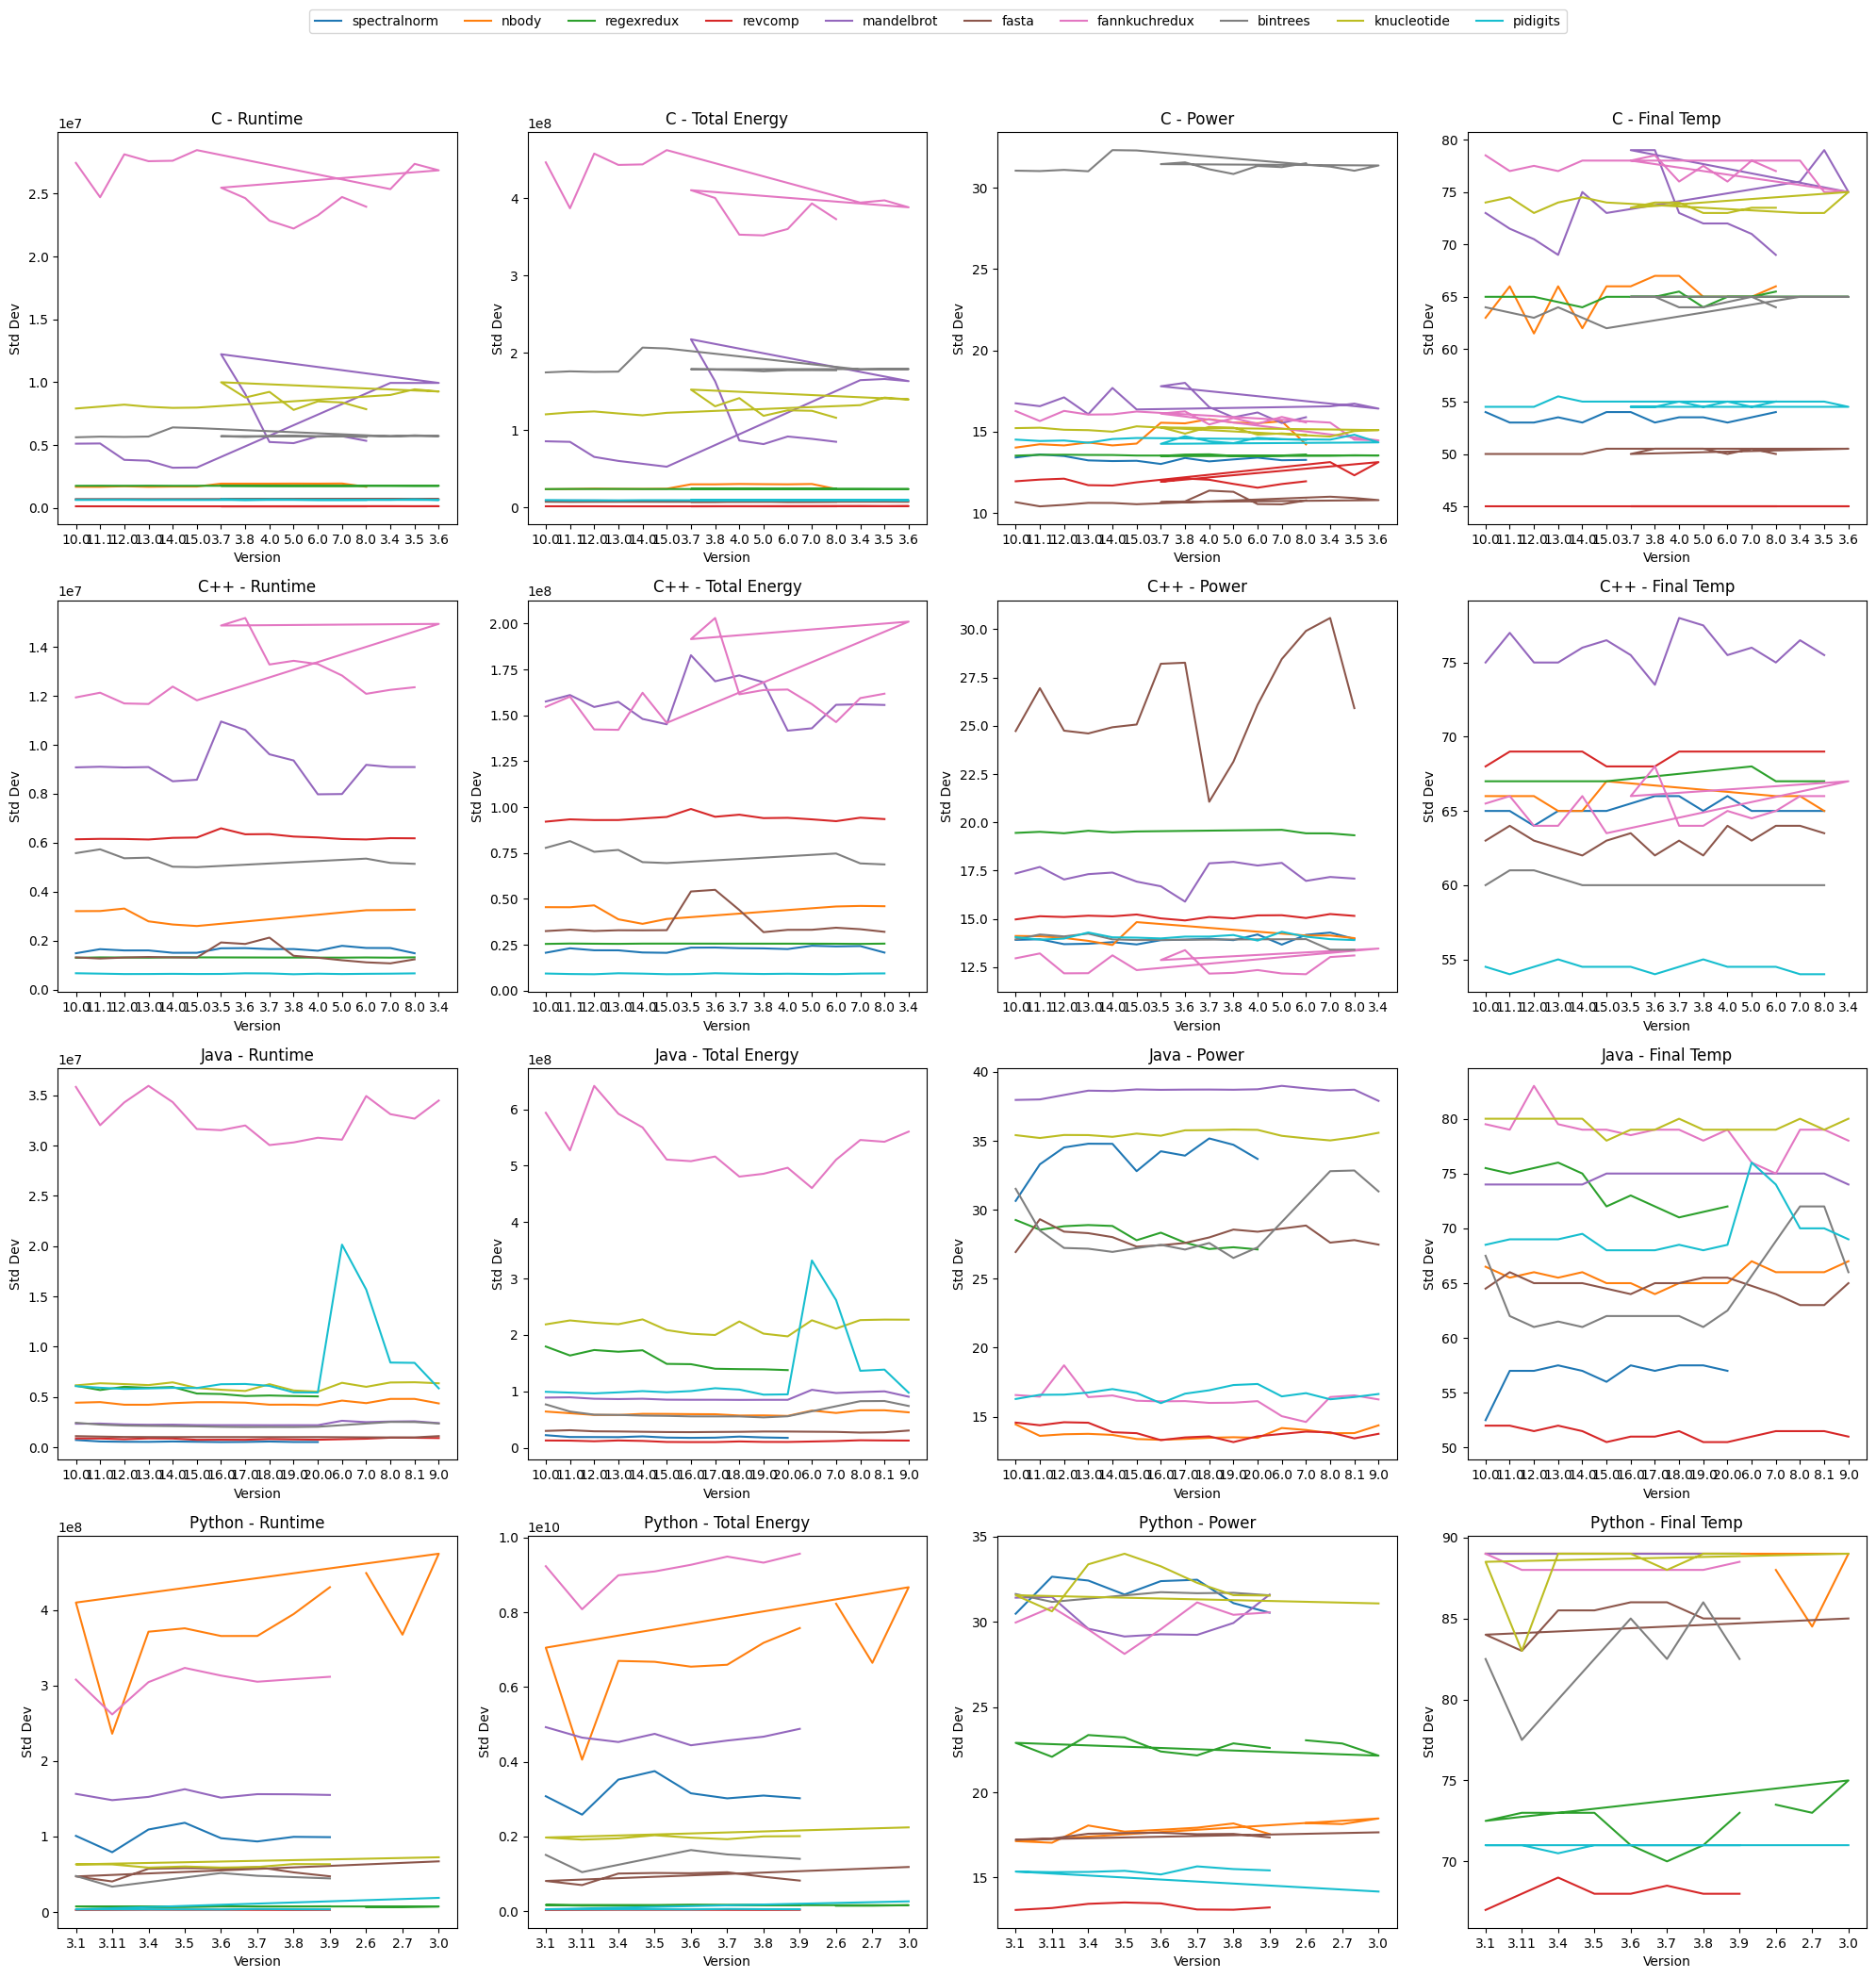

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_median(df):
    languages = df['Language'].unique()
    algorithms = df['Algorithm'].unique()
    metrics = ['Runtime', 'Total Energy', 'Power', 'Final Temp']
    order = [2.6, 2.7, 3.0, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 3.1, 3.11]

    # Number of rows and columns for the subplot
    nrows = len(languages)
    ncols = len(metrics)

    # Create a large figure to hold all the subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))

    # Ensure axes is a 2D array for easy indexing
    if nrows == 1:
        axes = np.array([axes])

    # Collect all lines for the common legend
    lines = []
    labels = []
    

    for i, language in enumerate(languages):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]  # Select the correct subplot
            for algo in algorithms:
                # Filter data for each language-algorithm-version
                subset = df[(df['Language'] == language) & (df['Algorithm'] == algo)].copy()
                # Sort versions; custom sort for Python
                if language == 'Python':
                    subset['Version'] = pd.Categorical(subset['Version'], categories=order, ordered=True)
                else:
                    subset['Version'] = pd.to_numeric(subset['Version'], errors='coerce')

                subset.sort_values(by='Version', inplace=True)
                subset['Version'] = subset['Version'].astype(str)
                # Calculate standard deviation for each version
                
                subset = subset.groupby('Version')[metric].median()
                line, = ax.plot(subset, label=algo)
               

                if algo not in labels:
                    lines.append(line)
                    labels.append(algo)
            
            ax.set_title(f'{language} - {metric}')
            ax.set_xlabel('Version')
            ax.set_ylabel('Std Dev')

            

    # Add a single legend for all subplots
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(algorithms))

    plt.tight_layout()
    plt.show()

# Assuming df is your DataFrame
# df = pd.read_csv('your_data_file.csv')  # Load your data here

plot_median(df)  # Call the function with your data

In [54]:

from scipy.stats import linregress
# General function to calculate percentage change across versions for a given variable
def calculate_percentage_change(df, languages, variable):
    percentage_change_dfs = {}
    for language in languages:
        language_data = df[df['Language'] == language]
        pivot_table = language_data.pivot_table(values=variable, index='Version', columns='Algorithm', aggfunc='mean')
        percentage_change = pivot_table.pct_change().fillna(0) * 100
        percentage_change_dfs[language] = percentage_change
    return percentage_change_dfs

# General function to plot trends for a given variable
def plot_trends(df, languages, variable):
    for language in languages:
        language_data = df[df['Language'] == language]
        algorithms = language_data['Algorithm'].unique()
        plt.figure(figsize=(14, 7))
        for algo in algorithms:
            algo_data = language_data[language_data['Algorithm'] == algo]
            version_data = algo_data.groupby('Version')[variable].mean().reset_index()
            plt.plot(version_data['Version'], version_data[variable], marker='o', label=algo)
        plt.title(f'{variable} Usage Trends Across Versions for {language} Language')
        plt.xlabel('Version')
        plt.ylabel(f'Mean {variable} Usage')
        plt.legend(title='Algorithm')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

# General function for regression analysis on a given variable
def analyze_usage_trends(df, languages, variable):
    analysis_results = {}
    for language in languages:
        language_data = df[df['Language'] == language]
        algorithms = language_data['Algorithm'].unique()
        for algo in algorithms:
            algo_data = language_data[language_data['Algorithm'] == algo]
            std_dev = algo_data[variable].std()
            mean_data_by_version = algo_data.groupby('Version')[variable].median().reset_index()
            slope, intercept, r_value, p_value, std_err = linregress(mean_data_by_version.index, mean_data_by_version[variable])
            analysis_results[f"{language}_{algo}"] = {
                'Standard Deviation': std_dev,
                'Slope of Trend': slope,
                'p-value of Trend': p_value
            }
    return analysis_results

# General function to filter and create a table of significant trends
def filter_significant_trends(analysis_results, significance_level=0.05):
    filtered_results = []
    for identifier, metrics in analysis_results.items():
        if metrics['p-value of Trend'] < significance_level:
            language, algo = identifier.split("_")
            filtered_results.append({
                'Language': language,
                'Algorithm': algo,
                'Standard Deviation': metrics['Standard Deviation'],
                'Slope of Trend': metrics['Slope of Trend'],
                'p-value of Trend': metrics['p-value of Trend']
            })
    return pd.DataFrame(filtered_results)

# Function to create a generalized interface for all operations
def perform_analysis(df, languages, variable):
    # # Calculate percentage change
    # pct_change_dfs = calculate_percentage_change(df, languages, variable)
    
    # # Plot trends
    # plot_trends(df, languages, variable)
    
    # Perform regression analysis
    usage_trends = analyze_usage_trends(df, languages, variable)
    
    # Filter significant trends
    significant_trends = filter_significant_trends(usage_trends)
    
    return significant_trends

In [55]:
languages_to_focus = ['C', 'C++', 'Java', 'Python']
variables_to_focus = ['Runtime', 'Total Energy', 'Power', 'Peak Memory', 'Final Temp']

var_dict = {}
for var in variables_to_focus:
    print(f"Analyzing {var}...")
    var_dict[var] = perform_analysis(df, languages_to_focus, var)

Analyzing Runtime...
Analyzing Total Energy...
Analyzing Power...
Analyzing Peak Memory...
Analyzing Final Temp...


In [66]:
df = pd.DataFrame()
for var in var_dict.keys():
    var_df = var_dict[var]
    var_df['Variable'] = var
    df = pd.concat([df, var_df], ignore_index=True)

res= df[df['Slope of Trend']<0] # filter out negative trends
# res= df[df['Slope of Trend']>0] # filter out positive trends
res = res.groupby(['Language', 'Variable'])['Algorithm'].count().unstack().fillna(0)
res.to_csv('negative.csv')
# res.to_csv('positive.csv') 
res

Variable,Final Temp,Peak Memory,Power,Runtime,Total Energy
Language,,,,,
C,3.0,0.0,3.0,5.0,6.0
C++,1.0,1.0,0.0,6.0,6.0
Java,5.0,1.0,3.0,8.0,8.0
Python,1.0,1.0,0.0,0.0,0.0
